## E.P.S.M. Project
- Lazy Evaluation of Goal Specifications Guided by Motion Planning <br/>Juan David Hern'andez, Mark Moll, and Lydia E. Kavraki
- Students: Petre Ovidiu Adrian (343C3) & Stanciu Stefan Lucian (343C5)
<br/>
### Clarifications
This project focuses on the implementation of the planning algorithm described in the paper and thus it completly disregards other aspects of the scenarios such as the semantic entity used to interpret ambiguous human requests.

### Planning algorithm implementation

In [4]:
from treelib import Node, Tree
from random import randint, choice
from heapq import heappop, heappush, heapify
from math import sqrt
from sys import maxsize
from math import floor
import matplotlib.pyplot as plt

EPS = 100

def isValid(x, y):
    """Checks if a point is inside Cfree or not"""
    if (c_space[x][y] == OBS):
        return False
    return True


def inGoalRegion(q):
    """Checks if a point is inside a GR or not"""
    print(q)
    if (gr[q[0]][q[1]] != GOAL):
        return False
    return True


def biasToGoal():
    return np.random.choice([True, False], p=[0.05, 0.95])


def goalRegionSampler():
    """Create a list of goal samples for each goal region"""
    heap = []
    heapify(heap)

    for gr in GR:
        top_left = gr[0]
        bottom_right = gr[1]
        x = y = -1
        while True:
            x = randint(top_left[0], bottom_right[0])
            y = randint(top_left[1], bottom_right[1])
            if (isValid(x, y)):
                break
        heappush(heap, (-1.0, (x, y)))
    return heap


def goalRegionResampler(old_heap):
    """Create a list of goal samples for each goal region and sets the existing ones weight to 0.5"""
    heap = [(-0.5, entry[1]) for entry in old_heap]
    # heapify(heap)

    for gr in GR:
        top_left = gr[0]
        bottom_right = gr[1]
        x = y = -1
        while True:
            x = randint(top_left[0], bottom_right[0])
            y = randint(top_left[1], bottom_right[1])
            if (isValid(x, y)):
                break
        heappush(heap, (-1.0, (x, y)))
    heap = heapsort(heap)
    return heap


def genRandomConf(heap):
    """Randomly selects one of the goal samples regardles of GR"""
    # heap_idx = randint(0, len(heap) - 1)
    # return (heap[heap_idx], heap_idx)
    x = y = -1
    while True:
        x = randint(0, C_SPACE_WIDTH - 1)
        y = randint(0, C_SPACE_HEIGHT - 1)
        if (isValid(x, y)):
            break
    return (x, y)

def distanceBetween(q, p):
    return sqrt((q[0]-p[0])**2+(q[1]-p[1])**2)


def findNearNeighbor(tree, q_towards):
    nodes = [(tree[node].tag, tree[node].identifier) for node in tree.expand_tree()]
    max_distance = maxsize
    ret_id = ''
    ret_tag = ()

    for tag, id in nodes:
        tmp_distance = distanceBetween(tag, q_towards)
        if tmp_distance < max_distance:
            max_distance = tmp_distance
            ret_id = id
            ret_tag = tag
    return (ret_tag, ret_id)


def calcMatrixDims(q, p):
    row_no = col_no = 0
    if (q[0] > p[0]):
        row_no = q[0] - p[0]
    else:
        row_no = p[0] - q[0]

    if (q[1] > p[1]):
        col_no = q[1] - p[1]
    else:
        col_no = p[1] - q[1]
    return (row_no, col_no)


def calcMatrixRatio(row_no, col_no):
    if (row_no < col_no):
        return floor(col_no / row_no)
    else:
        return floor(row_no / col_no)


def calcNewState(q_near, q_towards):
    tag_near = q_near[0]
    # DEV: 1 -- to the right/down, -1 -- to the left/up
    x_axis = 1
    if (tag_near[0] < q_towards[0]):
        x_axis = 1
    else:
        x_axis = -1

    y_axis = 1
    if (tag_near[1] < q_towards[1]):
        y_axis = 1
    else:
        y_axis = -1
    
    row_no, col_no = calcMatrixDims(tag_near, q_towards)
    ratio = calcMatrixRatio(row_no, col_no)
    ir = jr = 1

    if (row_no > col_no):
        ir = ist = ratio
    else:
        jr = jst = ratio

    # print(q_near, q_towards, ir, jr, x_axis, y_axis, ratio)
    
    success = False
    ret_state = ()
    prev_distance = -1
    for i in range(tag_near[0], row_no, ir * x_axis):
        for j in range(tag_near[1], row_no, jr * y_axis):
            new_distance = distanceBetween(tag_near, (i, j))
            if (isValid(i, j) and new_distance < EPS and new_distance > prev_distance):
                ret_state = (i, j)
                success = True
                prev_distance = new_distance
    return (ret_state, success)


def heapsort(iterable):
    h = []
    for value in iterable:
        heappush(h, value)
    return [heappop(h) for i in range(len(h))]


def rewardGoalSample(heap):
    q = heap[0]
    weight = -1 * q[0]
    if (0 < weight < 1.0):
        weight = weight / (1.0 - weight) * -1
    heap[0] = (weight, q[1])
    heap = heapsort(heap)


def penalizeGoalSample(heap):
    q = heap[0]
    weight = -1 * q[0]
    if (weight > 0):
        weight = weight / (weight + 1.0) * -1
    heap[0] = (weight, q[1])
    heap = heapsort(heap)


def calcPath(tree, q_new, q_near_id):
    paths = tree.paths_to_leaves()
    path_ids = []
    for path in paths:
        if path[-1] == q_near_id:
            path_ids = path
            break
    return [tree.get_node(id).tag for id in path_ids] + [q_new]


def plan(qs):
    path = []
    goal_biased = False
    tree = Tree()
    tree.create_node(qs, "qs")

    nodes = np.zeros((1020, 1020))

    g_heap = goalRegionSampler()
    plt.figure()
    failed_count = 0
    while True:
        if (biasToGoal()):
            q_towards = g_heap[0]
            goal_biased = True
        else:
            q_towards = (0, genRandomConf(g_heap))
            goal_biased = False
        q_near = findNearNeighbor(tree, q_towards[1])
        q_new, success = calcNewState(q_near, q_towards[1])
        # print(q_new)
        if (q_new != ()):
            # pass
            nodes = fill(nodes, q_new, (q_new[0]+20, q_new[1]+20), NODE)
            plt.clf()
            plt.imshow(nodes, interpolation='none')
            plt.show()
        else:
            failed_count = failed_count + 1
            # print(g_heap)
            if (failed_count == 20):
                g_heap = goalRegionResampler(g_heap)
                failed_count = 0
        if success:
            if (inGoalRegion(q_new)):
                path = calcPath(tree, q_new, q_near[1])
                return (tree, path)
            tree.create_node(q_new, str(tree.size()), parent=q_near[1])
            if goal_biased:
                rewardGoalSample(g_heap)
        elif goal_biased:
            penalizeGoalSample(g_heap)

### Input data
The following plot represents a bidimentional space C (Cfree U Cobs) on which the algorith will be applied.

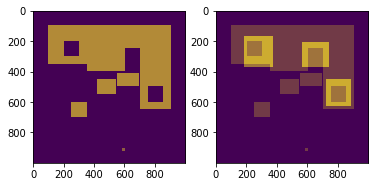

In [5]:
import numpy as np

C_SPACE_WIDTH = 1000
C_SPACE_HEIGHT = 1000

OBS = 1
GOAL = 2
NODE = 3

OBS_LIST = [((100, 100), (200, 900)),
            ((200, 100), (350, 200)),
            ((300, 200), (350, 300)),
            ((200, 300), (350, 350)),
            ((200, 350), (400, 600)),
            ((200, 600), (250, 700)),
            ((410, 550), (500, 690)),
            ((450, 420), (550, 540)),
            ((200, 700), (500, 900)),
            ((500, 700), (600, 750)),
            ((500, 850), (600, 900)),
            ((600, 700), (650, 900))]
GR = [((170, 180), (370, 370)),
    ((210, 560), (370, 740)),
    ((450, 720), (630, 880))]

def fill(matrix, start, end, val):
    """Create zones by providing top left and bottom right coordinates in a matrix"""
    for i in range(start[0], end[0]):
        for j in range(start[1], end[1]):
            matrix[i][j] = val
    return matrix

c_space = np.zeros((C_SPACE_HEIGHT, C_SPACE_WIDTH))
gr = np.zeros((C_SPACE_HEIGHT, C_SPACE_WIDTH))
nodes = np.zeros((C_SPACE_HEIGHT, C_SPACE_WIDTH))

# DEV: te rog lasa o linie libera intre figuri care nu se ating
# Create Cobs
c_space = fill(c_space, (100, 100), (200, 900), OBS)
c_space = fill(c_space, (200, 100), (350, 200), OBS)
c_space = fill(c_space, (300, 200), (350, 300), OBS)
c_space = fill(c_space, (200, 300), (350, 350), OBS)
c_space = fill(c_space, (200, 350), (400, 600), OBS)
c_space = fill(c_space, (200, 600), (250, 700), OBS)

c_space = fill(c_space, (600, 250), (700, 350), OBS)

c_space = fill(c_space, (410, 550), (500, 690), OBS)

c_space = fill(c_space, (450, 420), (550, 540), OBS)

c_space = fill(c_space, (200, 700), (500, 900), OBS)
c_space = fill(c_space, (500, 700), (600, 750), OBS)
c_space = fill(c_space, (500, 850), (600, 900), OBS)
c_space = fill(c_space, (600, 700), (650, 900), OBS)

# Create Goal Regions
# GR1
gr = fill(gr, (170, 180), (370, 370), GOAL)
# GR2
gr = fill(gr, (210, 560), (370, 740), GOAL)
# GR3
gr = fill(gr, (450, 720), (630, 880), GOAL)

# Create qs - start node
# DEV: (920, 500) sunt pentru a putea vedea punctul pe plot
qs = (900, 580)
nodes = fill(nodes, qs, (qs[0]+20, qs[1]+20), NODE)

# Display matrix
plt.figure()
plt.subplot(1,2,1)
plt.imshow(nodes, interpolation='none')
plt.imshow(c_space, interpolation='none', alpha=0.6)
plt.subplot(1,2,2)
plt.imshow(nodes, interpolation='none')
plt.imshow(c_space, interpolation='none', alpha=0.5)
plt.imshow(gr, interpolation='none', alpha=0.5)
plt.show()

### The algorithm in action

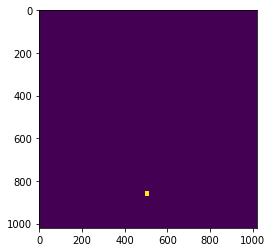

(849, 494)


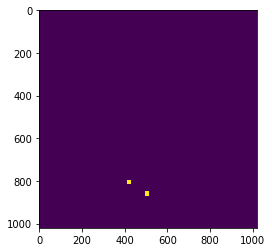

(795, 410)


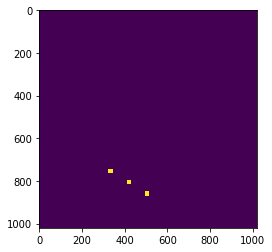

(744, 324)


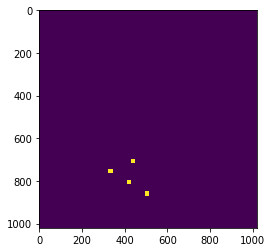

(697, 429)


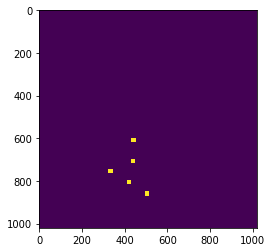

(599, 432)


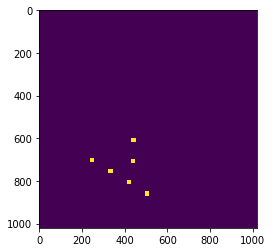

(693, 238)


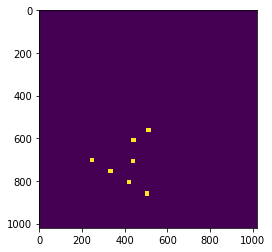

(550, 502)


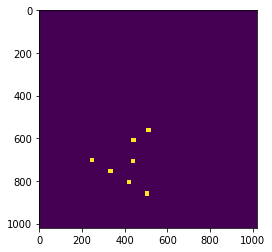

(550, 505)


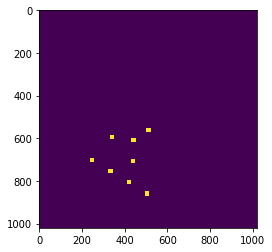

(585, 333)


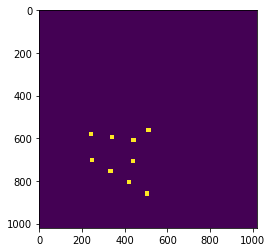

(571, 234)


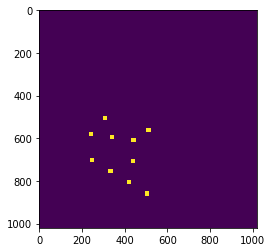

(495, 298)


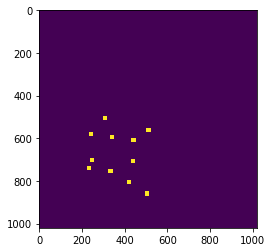

(730, 225)


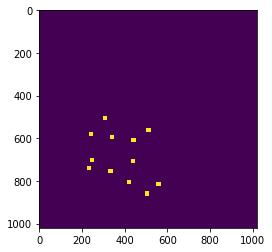

(805, 549)


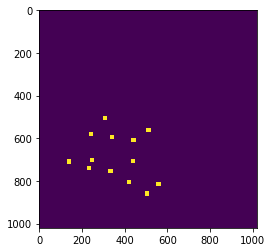

(699, 130)


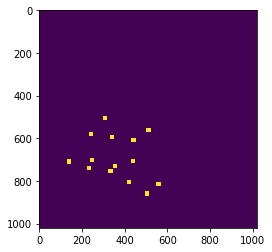

(720, 344)


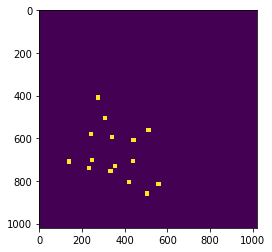

(400, 267)


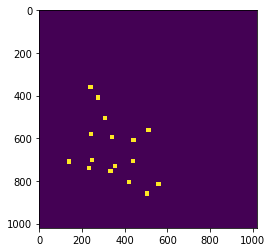

(350, 231)


In [6]:
tree, path = plan(qs)

In [7]:
tree.show()

(900, 580)
├── (805, 549)
└── (849, 494)
    └── (795, 410)
        ├── (697, 429)
        │   └── (599, 432)
        │       ├── (550, 502)
        │       │   └── (550, 505)
        │       └── (585, 333)
        │           └── (571, 234)
        │               └── (495, 298)
        │                   └── (400, 267)
        ├── (720, 344)
        └── (744, 324)
            ├── (693, 238)
            └── (730, 225)
                └── (699, 130)

